In [1]:
%pylab inline
import numpy as np
import pandas as pd
import xgboost as xgb
from uplift.models import SoloModel
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_clients = pd.read_csv('data/clients.csv', index_col='client_id')
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')

# Извлечение признаков

df_clients['first_issue_time'] = \
    (pd.to_datetime(df_clients['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_clients['first_redeem_time'] = \
    (pd.to_datetime(df_clients['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_clients['issue_redeem_delay'] = df_clients['first_redeem_time'] \
    - df_clients['first_issue_time']
df_clients = df_clients.drop(['first_issue_date', 'first_redeem_date'], axis=1)

df_features = pd.DataFrame({
    'gender_M': (df_clients['gender'] == 'M').astype(int),
    'gender_F': (df_clients['gender'] == 'F').astype(int),
    'gender_U': (df_clients['gender'] == 'U').astype(int),
    'age': df_clients['age'],
    'first_issue_time': df_clients['first_issue_time'],
    'first_redeem_time': df_clients['first_redeem_time'],
    'issue_redeem_delay': df_clients['issue_redeem_delay'],
}).fillna(0)


print("признаки")
df_features = df_features.loc[df_features.index.isin(df_train.index)]

indices_train = df_train.index

признаки


In [3]:
X_train = df_features.loc[indices_train, :]
y_train = df_train.loc[indices_train, 'target']
treat_train = df_train.loc[indices_train, 'treatment_flg']
print(X_train.shape)
print(y_train.shape)
print(treat_train.shape)
print(y_train)

(200035, 7)
(200035,)
(200035,)
client_id
000012768d    1
000036f903    1
00010925a5    1
0001f552b0    1
00020e7b18    1
000220a0a7    1
00022fd34f    1
0002ce2217    1
00031cbbe6    1
00035a21d9    0
00038f9200    1
0004231e2a    0
0004254599    0
00042a927a    1
0004315e57    1
00047b3720    0
0004e1e14e    0
00065f11c7    1
00068fd5dc    0
0006b9ad75    1
0006f24465    1
0006fca4bf    0
000702109b    1
00071890c8    1
0007667c60    1
00078c508d    1
0007b4ca21    0
0008244fb3    1
00083b5b14    0
0008b2cb41    1
             ..
fff4844212    0
fff4b5c0a5    1
fff597059d    1
fff66442e1    1
fff71bfb89    1
fff72e9dbb    0
fff73c7cc8    1
fff741a4f0    1
fff7cca176    1
fff7fa24ca    0
fff8604e27    1
fff866484c    1
fff9229003    1
fff93c52e3    1
fff989a7a9    0
fff9aa288c    0
fff9f772f6    1
fffa7299cf    1
fffb19ee74    1
fffb36a724    0
fffb52b456    0
fffb9a1eaa    1
fffbdaf8ed    0
fffc2e37ab    1
fffc2eadcb    0
fffcb91f10    0
fffd5cd0c6    1
fffd63dfe3    1
fffd8c9d7d    

##  solo, cross validation 5, фиксируем шаг(learning rate), оптимизируем по числу деревьев (рассматриваем xgboost, lgbm)

In [4]:
num_folds = 5
val_count = (df_train.shape[0]) // num_folds #volume of validation set
train_count = (df_train.shape[0]) - val_count
print(val_count)
print(train_count)
print(df_train.shape[0])

40007
160028
200035


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258:

d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarni

d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: Runti

d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: Runti

d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: Runti

d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: Runti

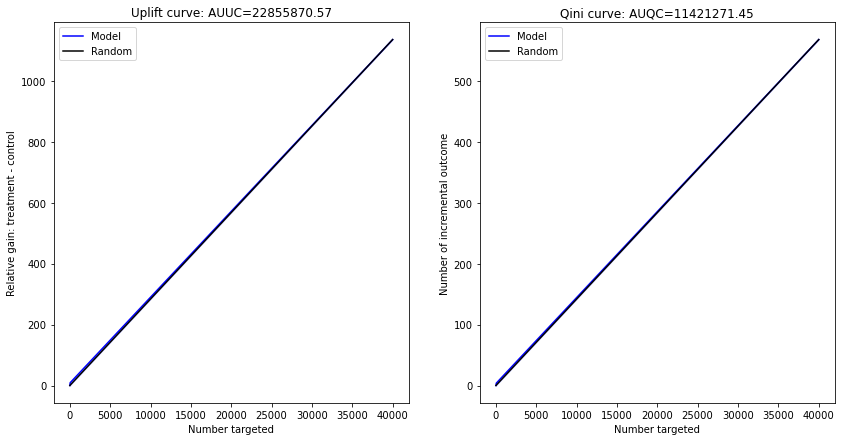

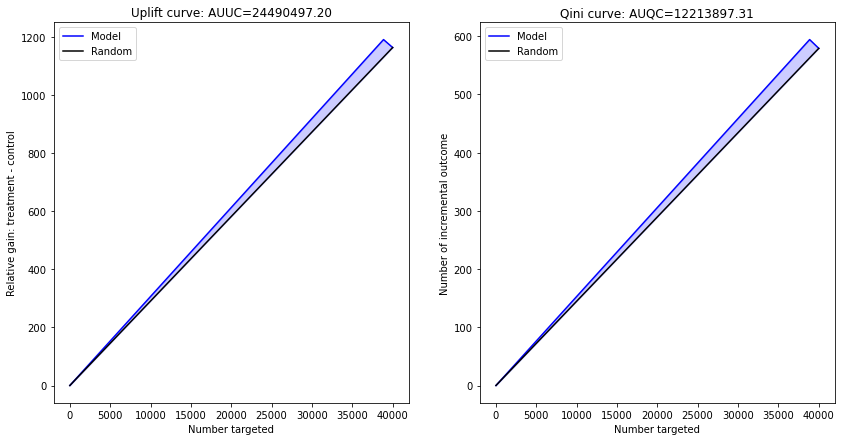

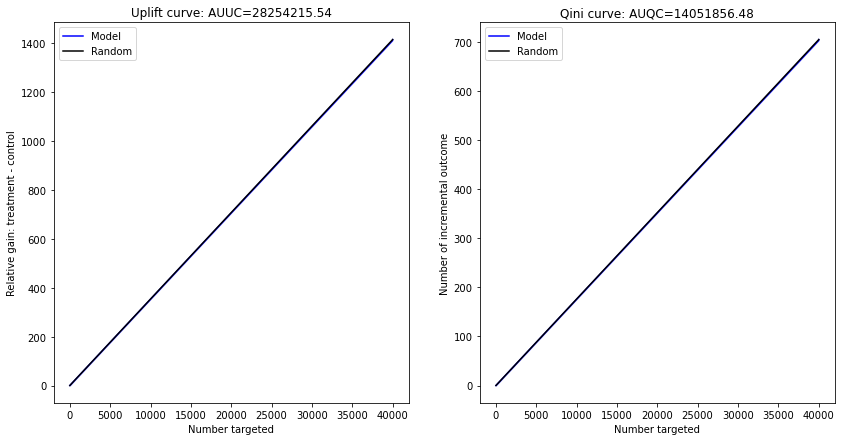

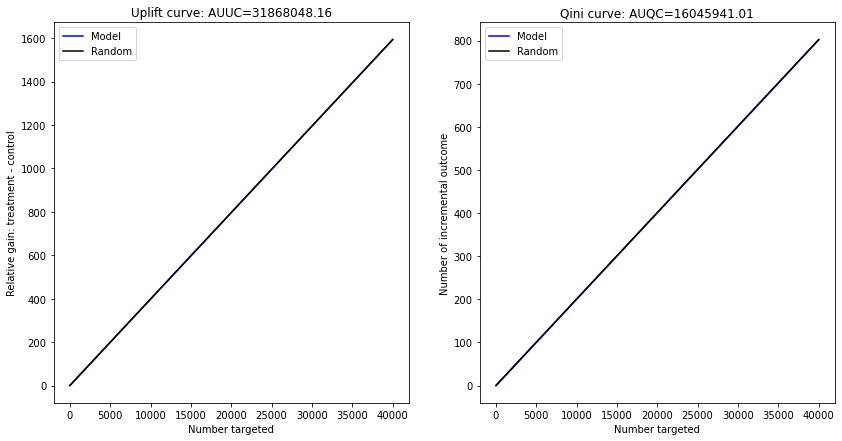

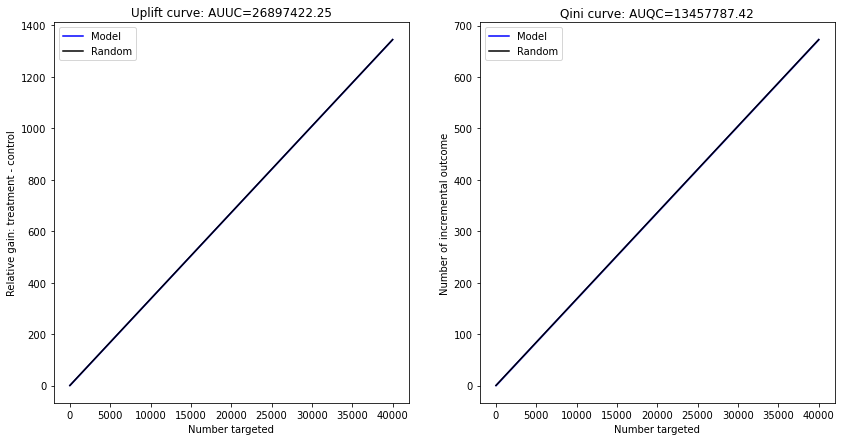

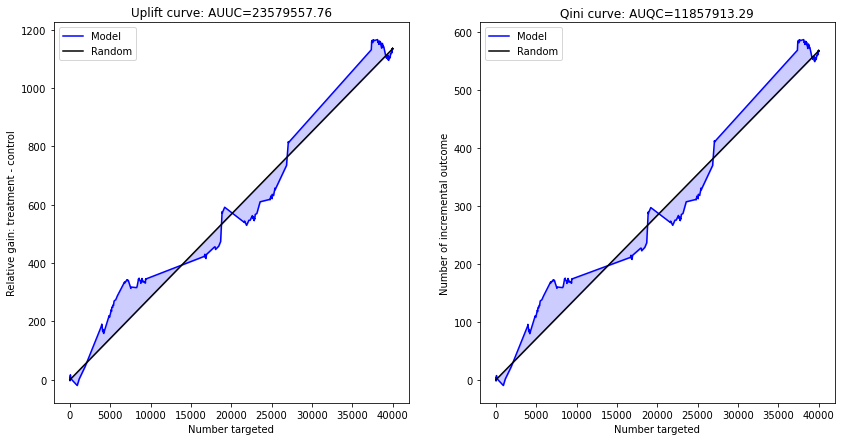

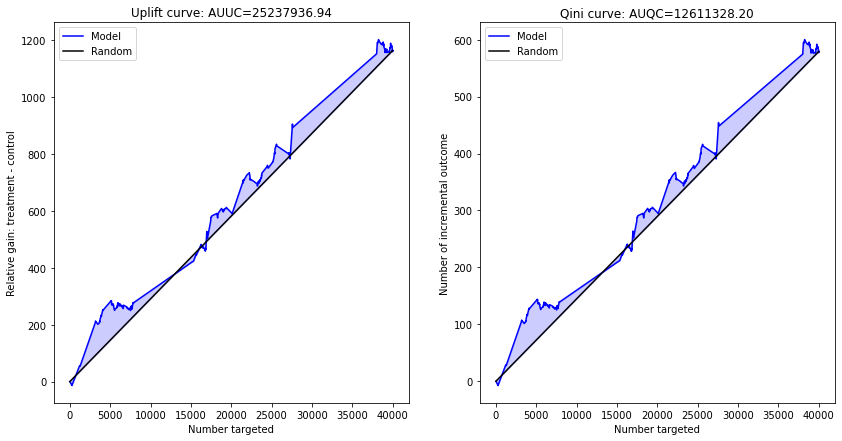

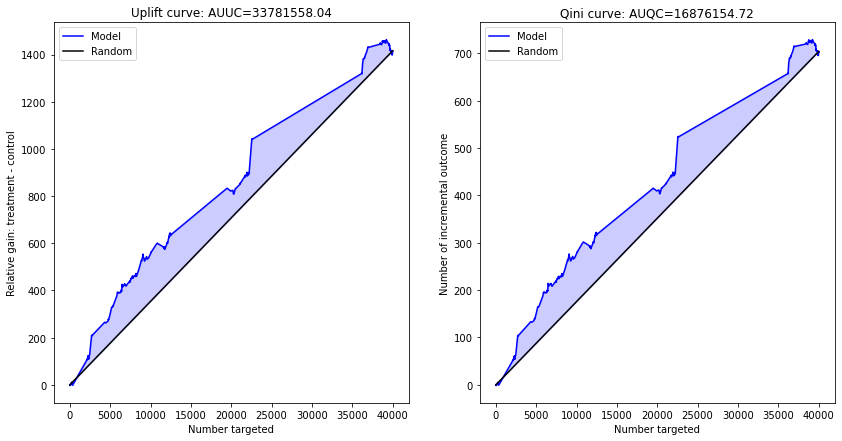

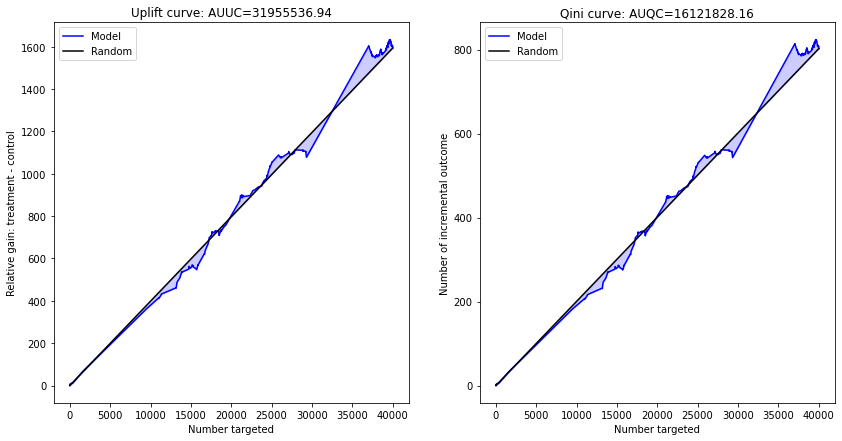

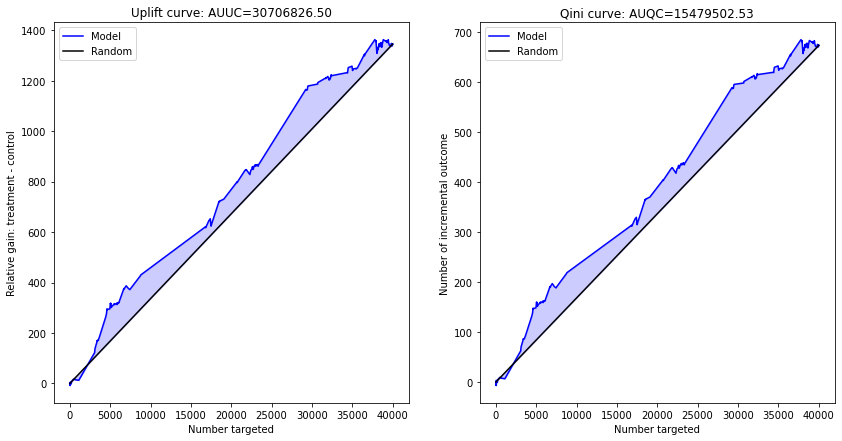

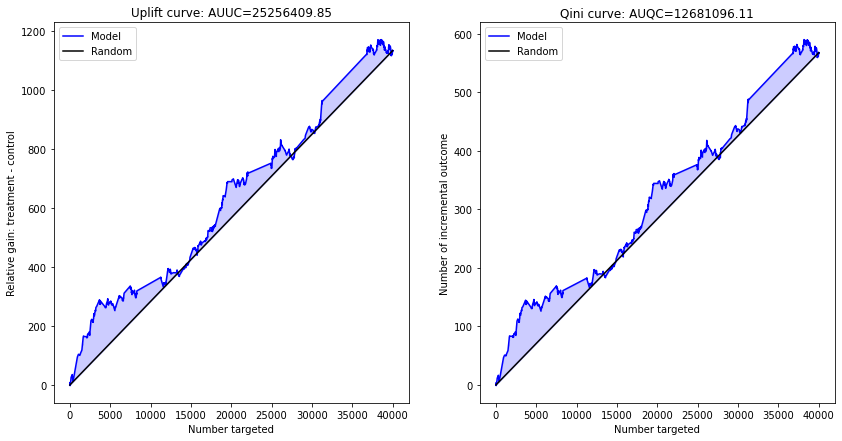

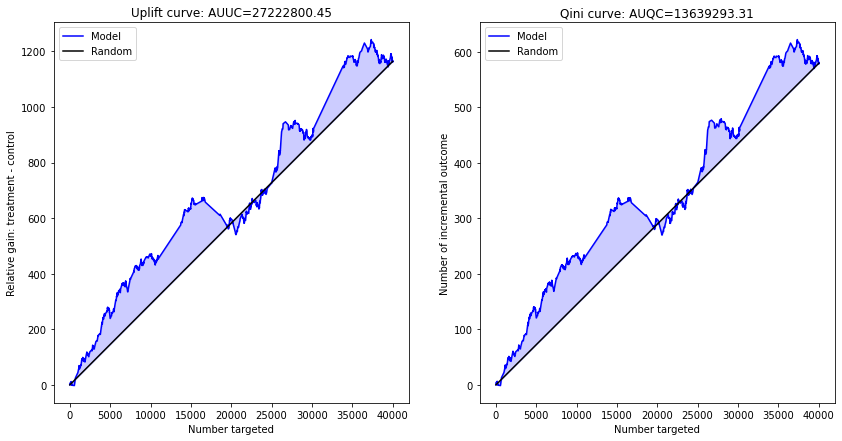

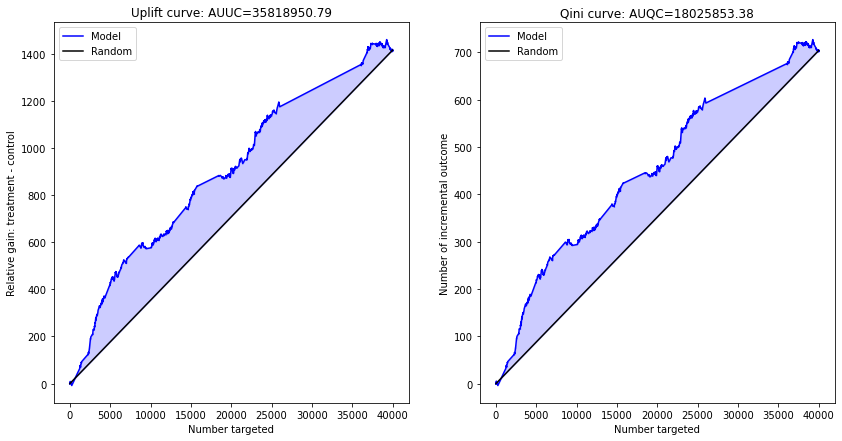

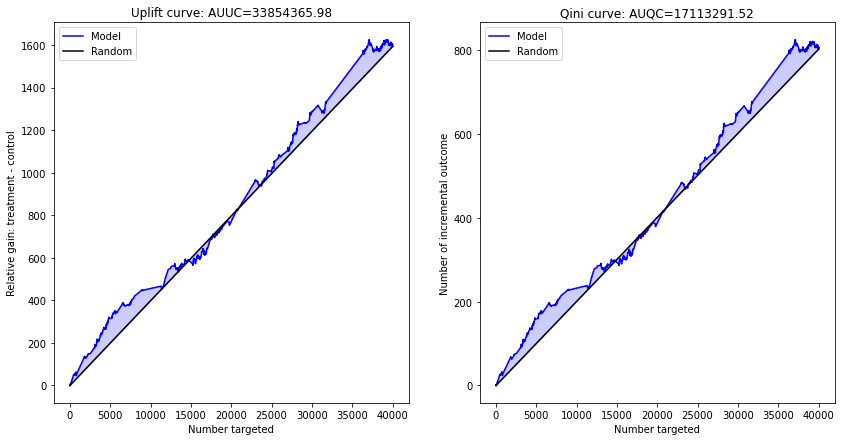

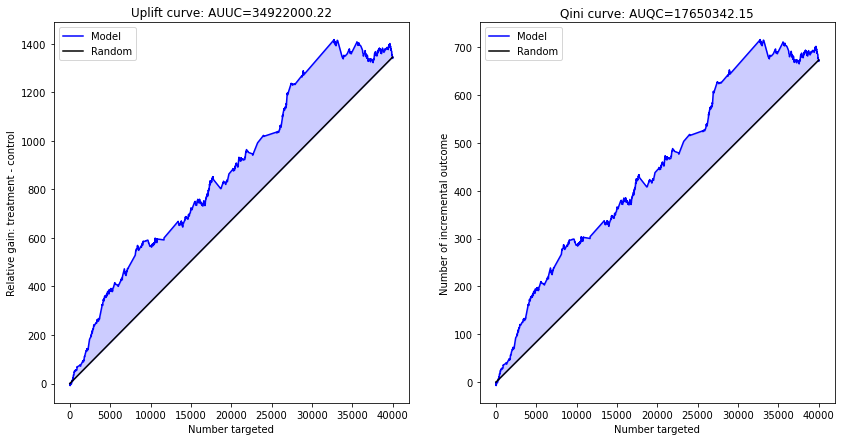

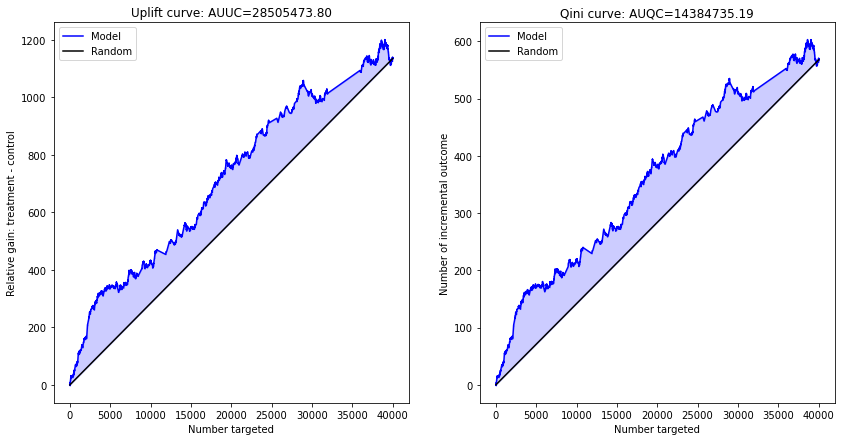

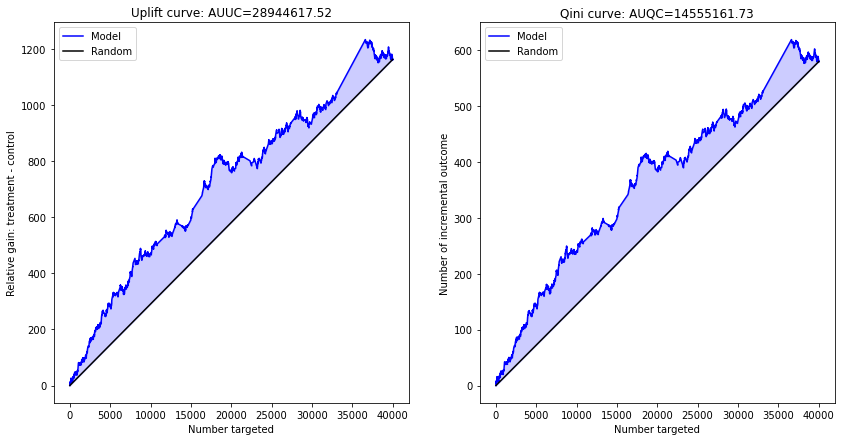

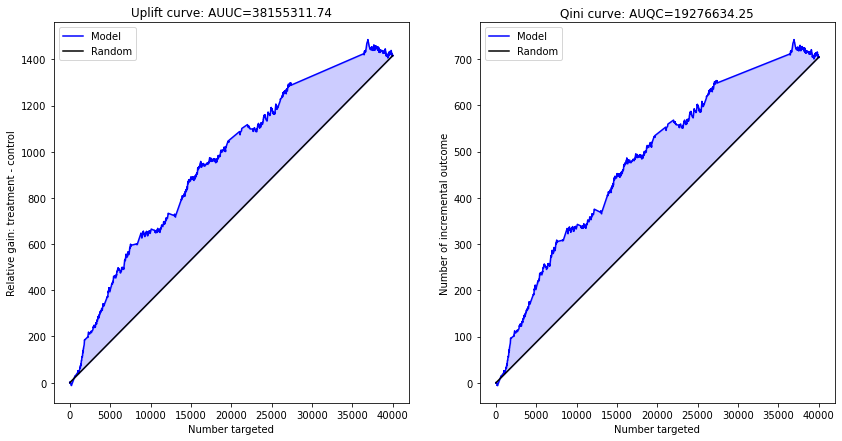

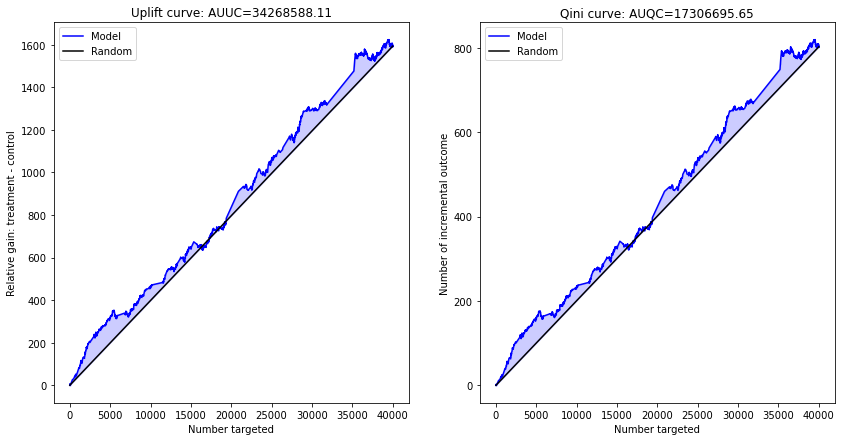

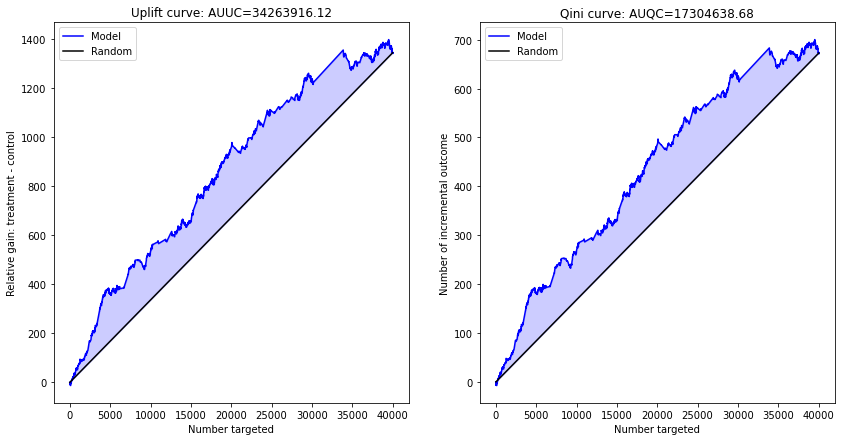

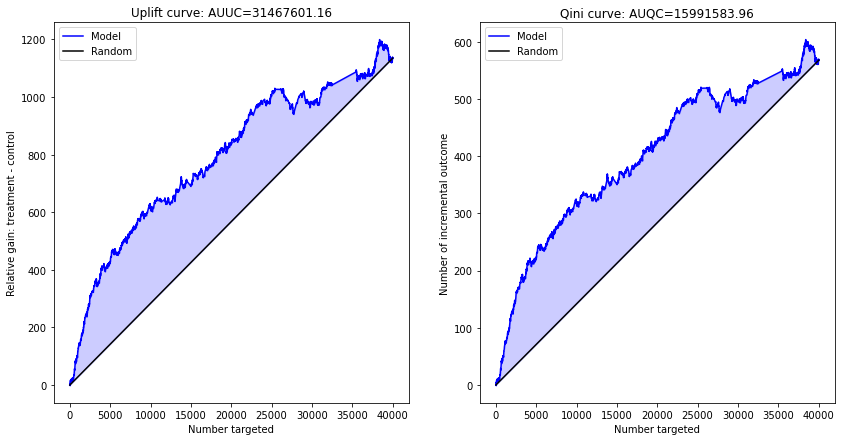

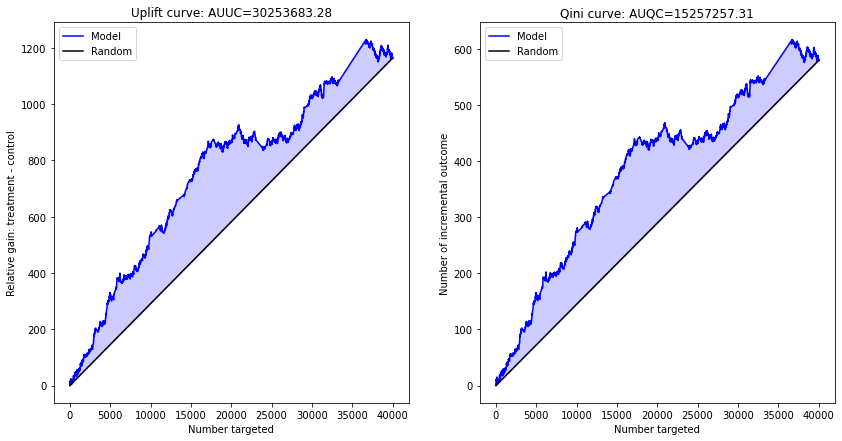

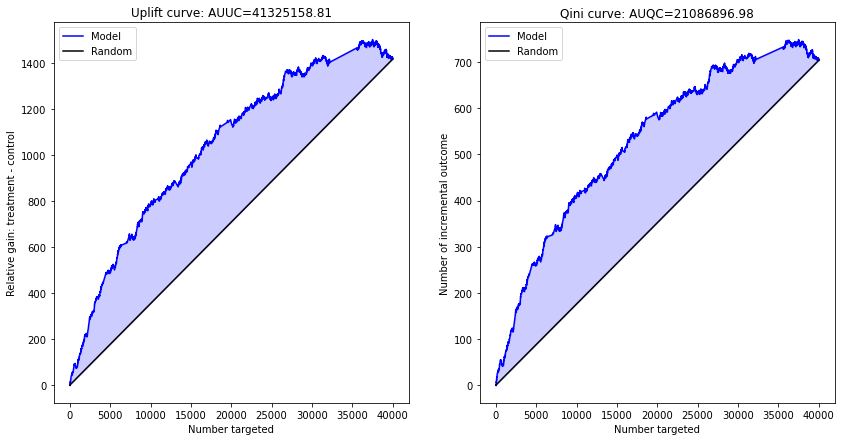

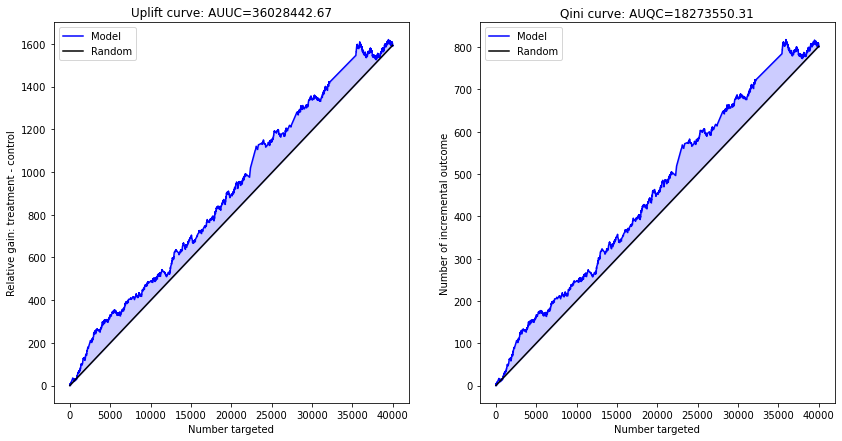

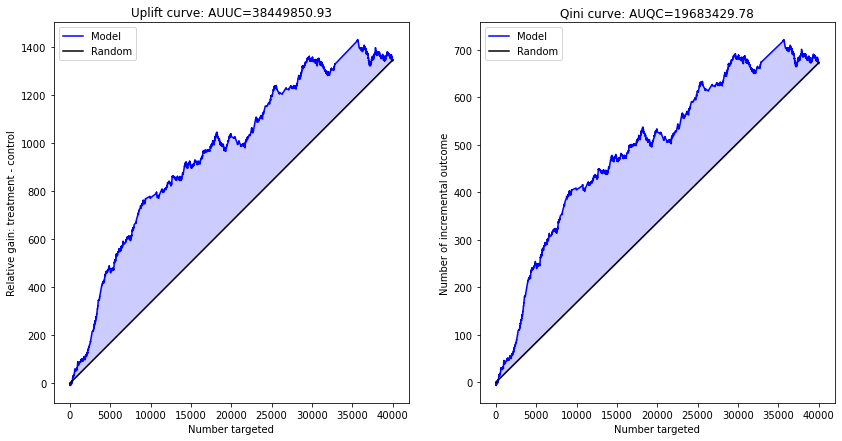

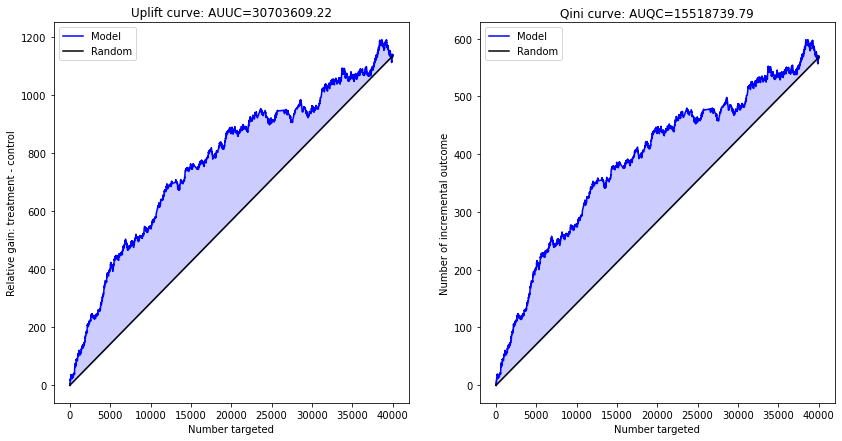

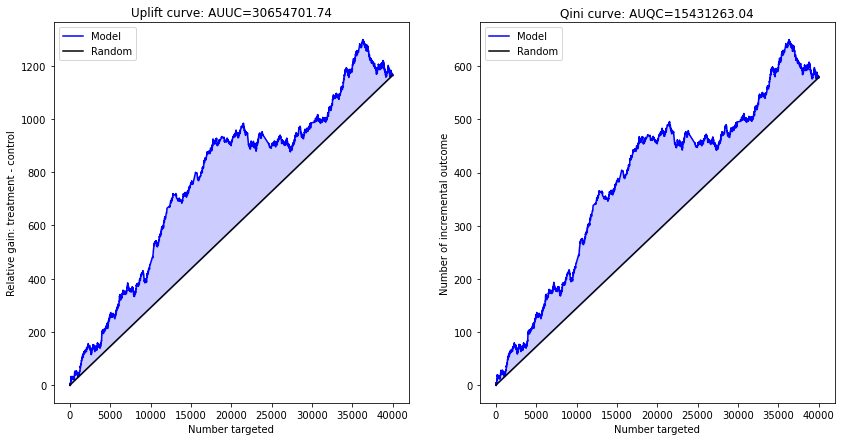

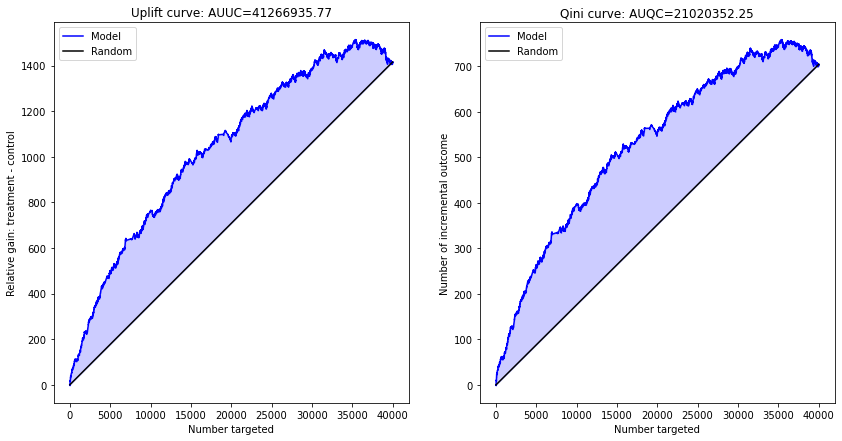

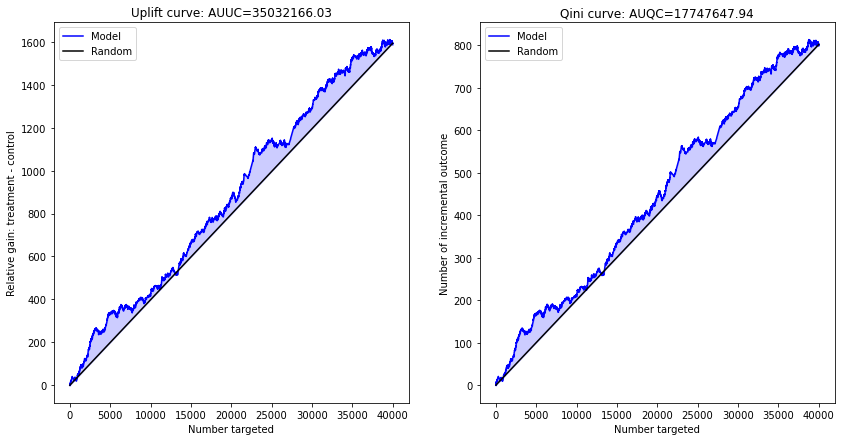

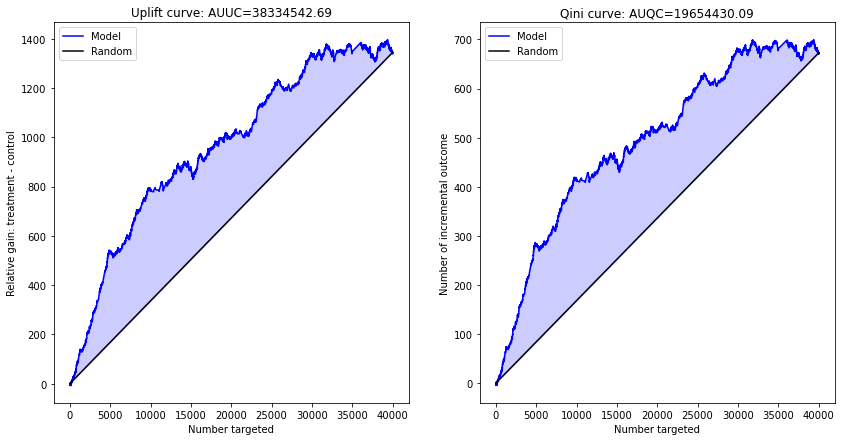

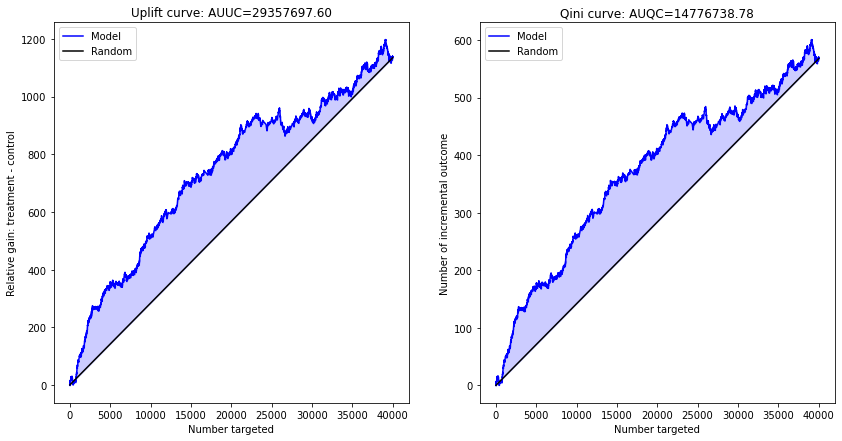

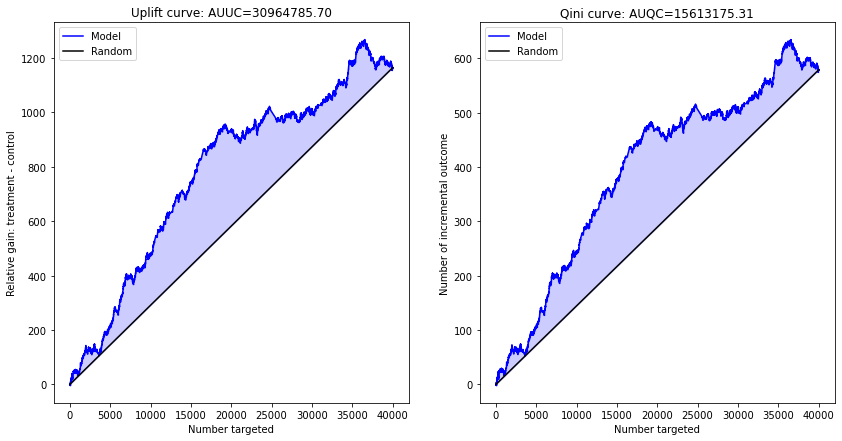

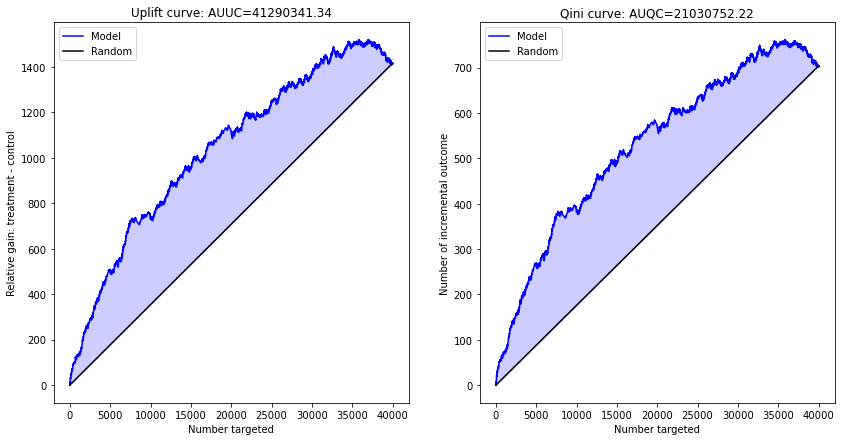

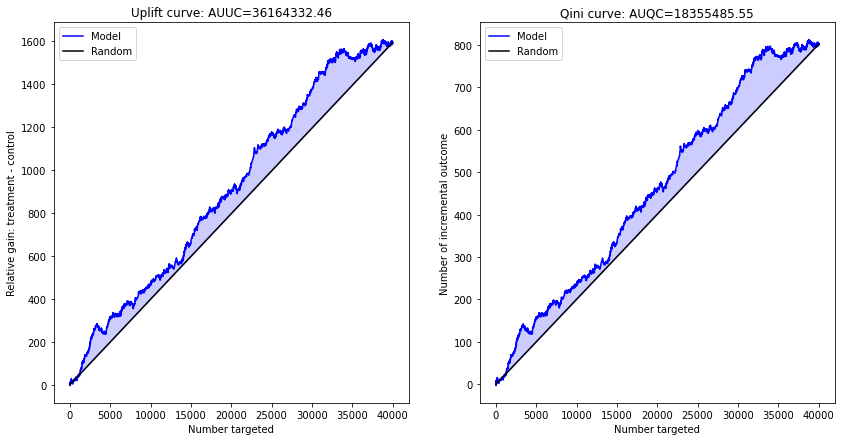

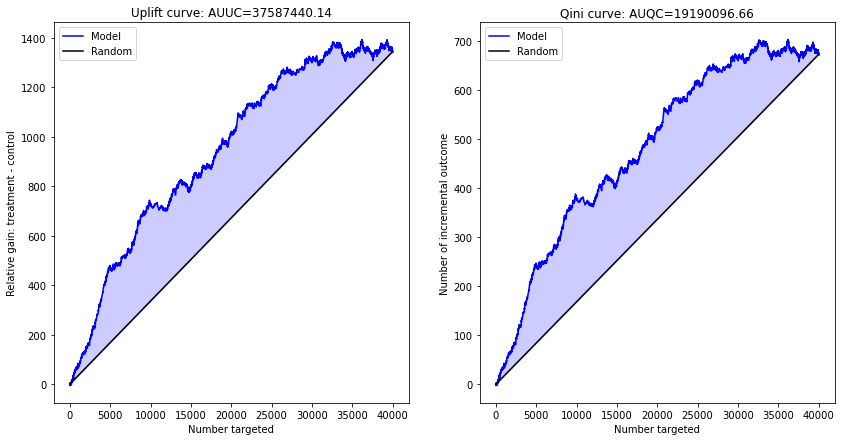

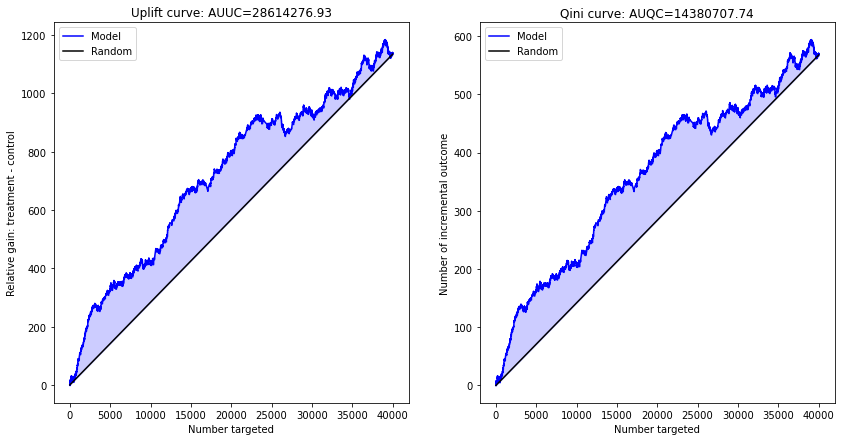

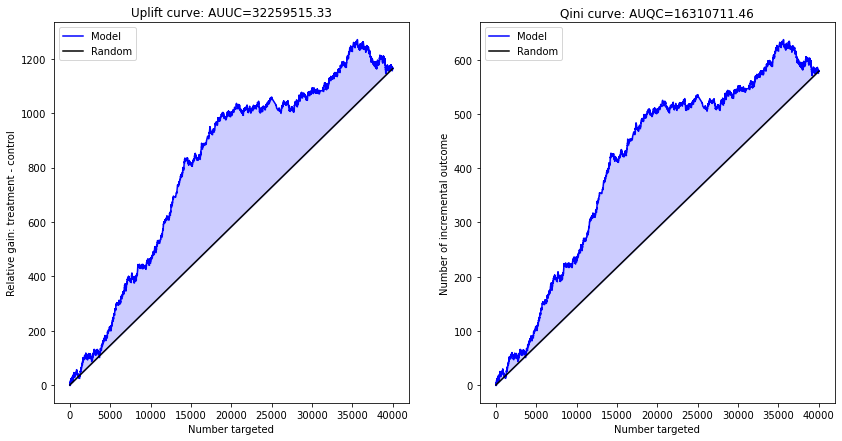

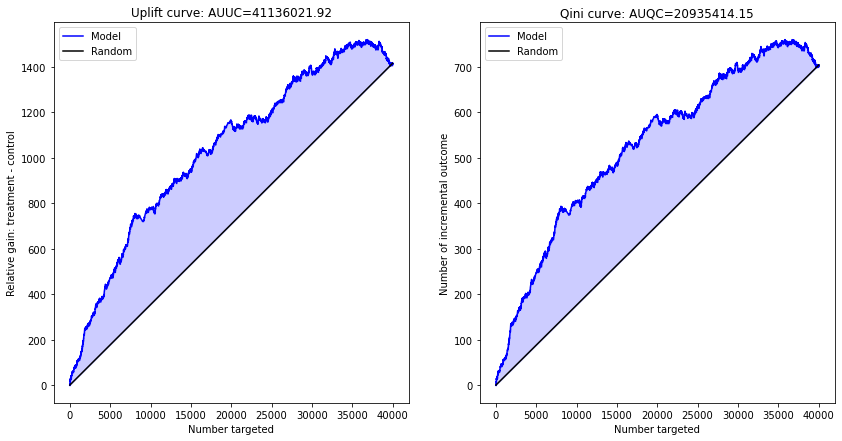

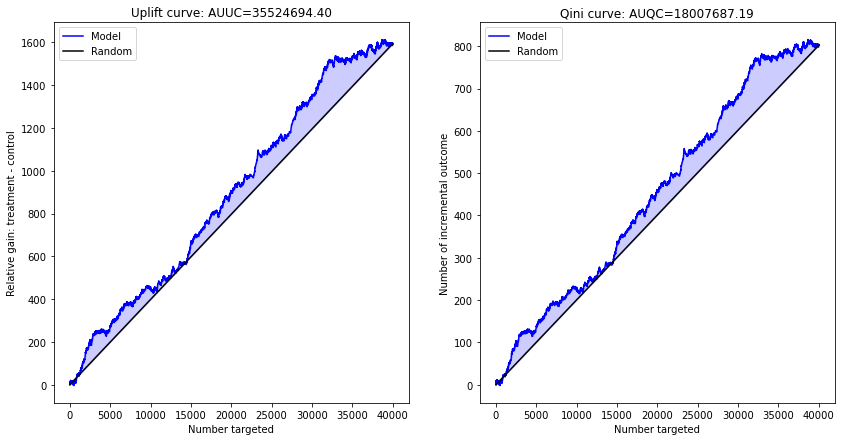

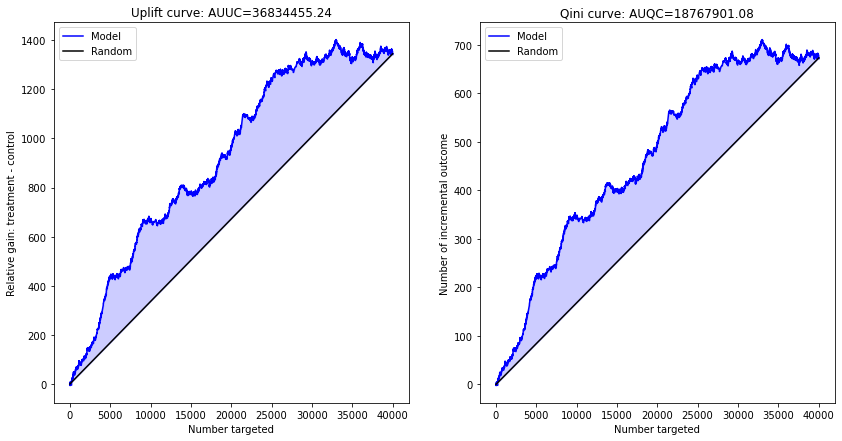

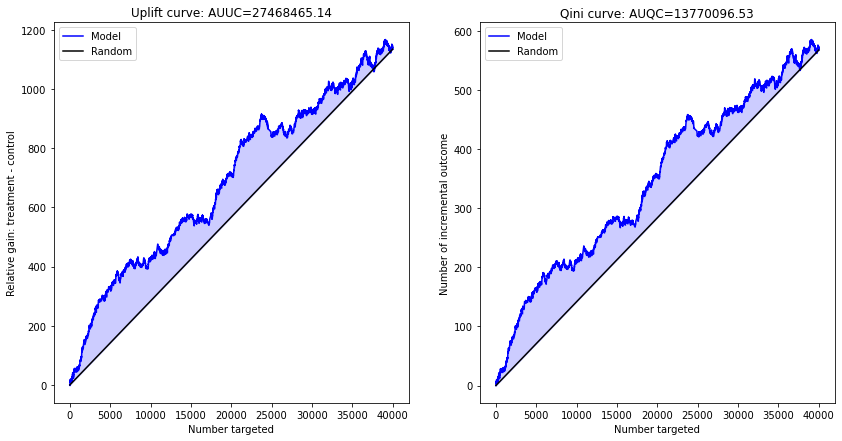

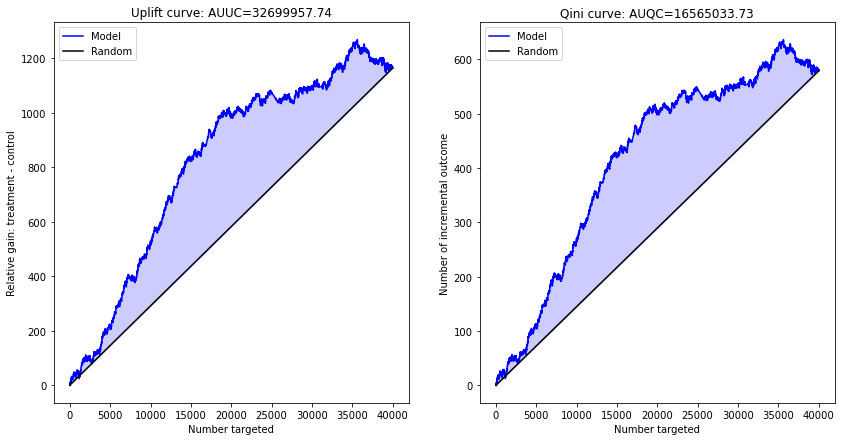

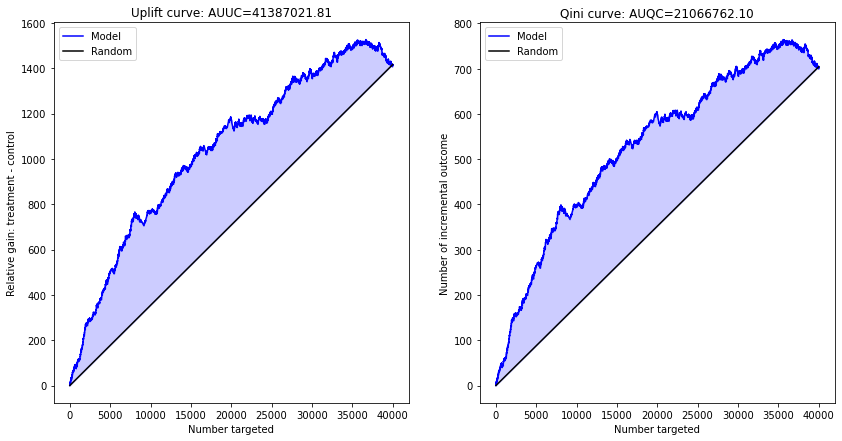

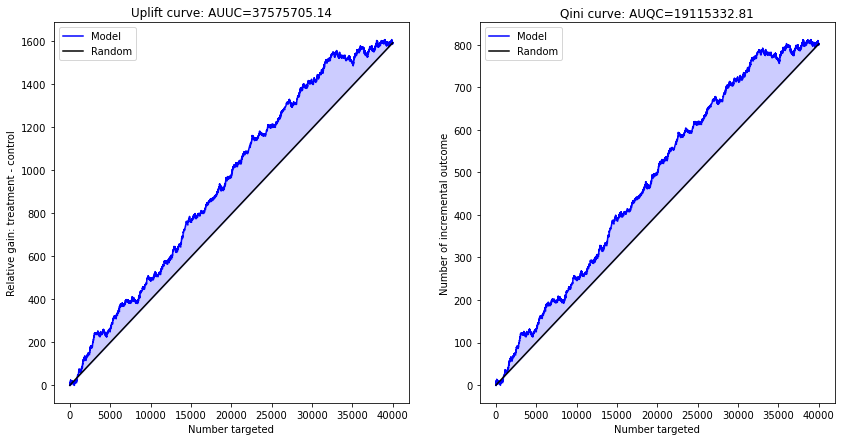

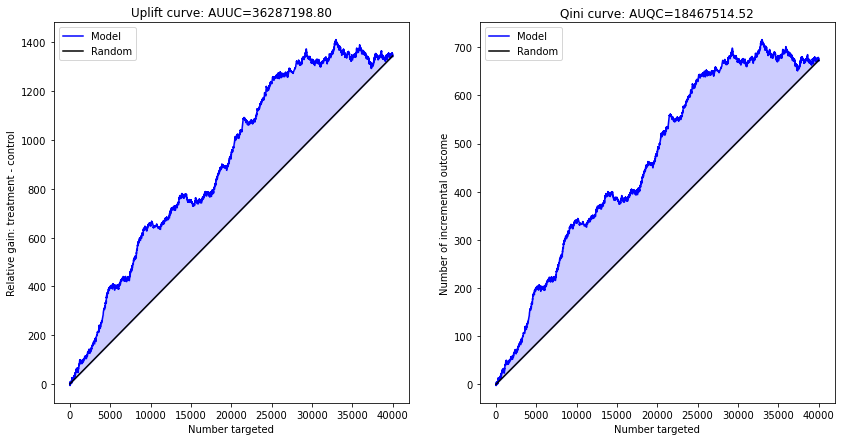

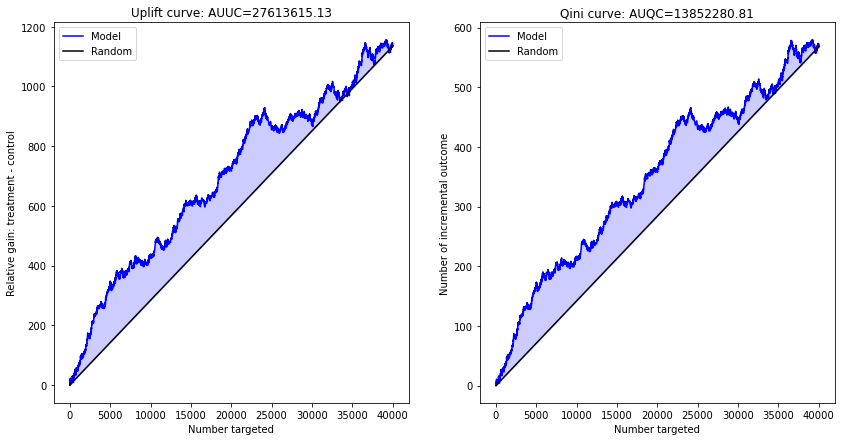

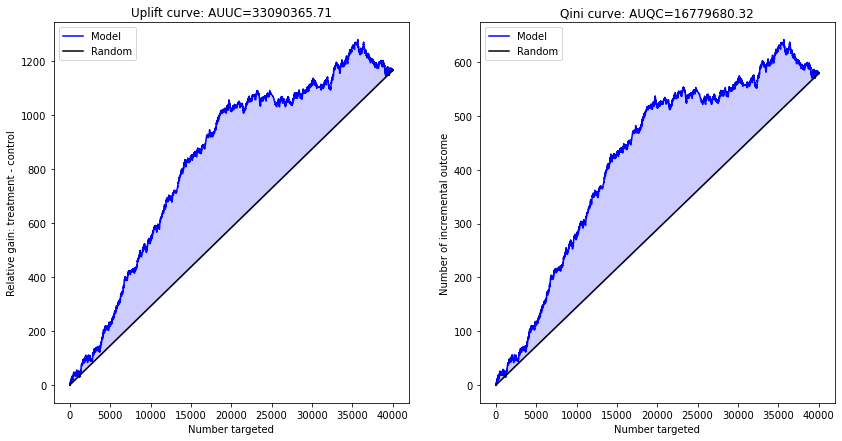

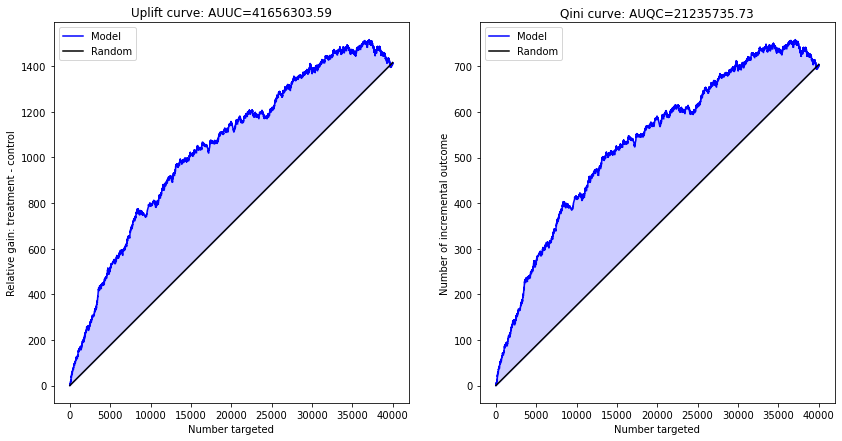

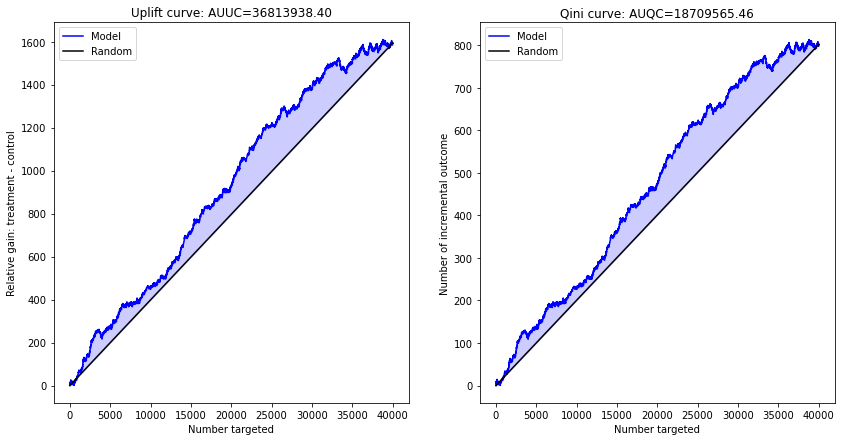

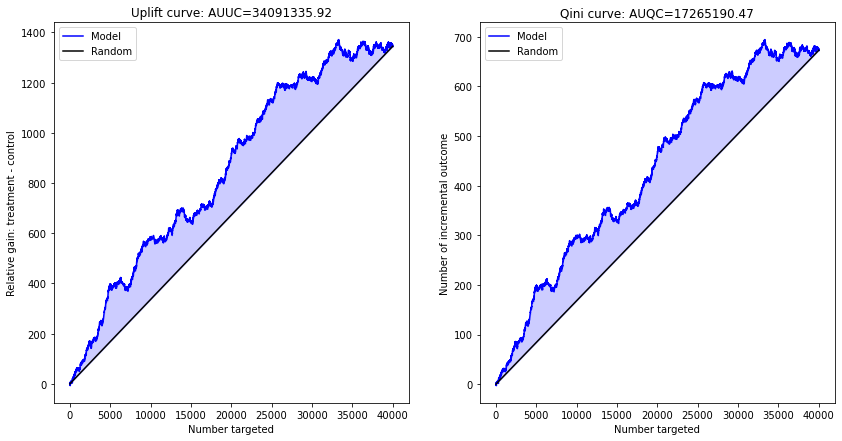

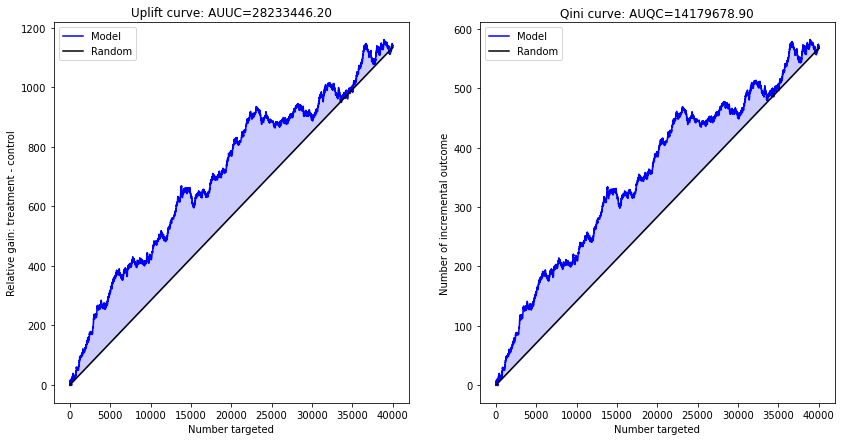

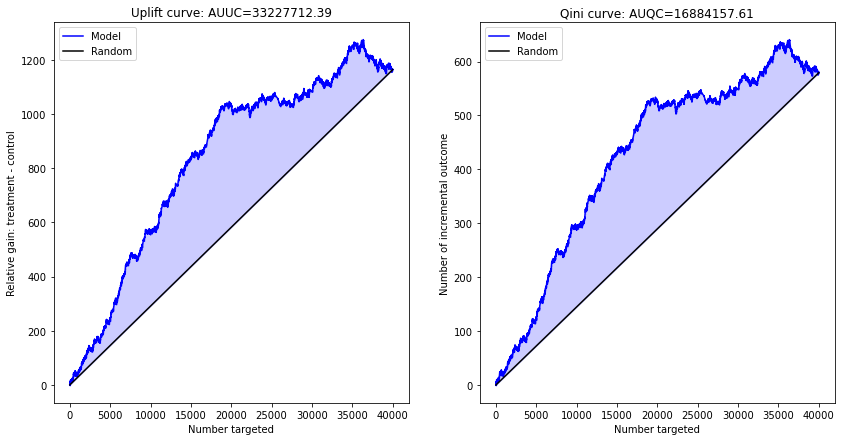

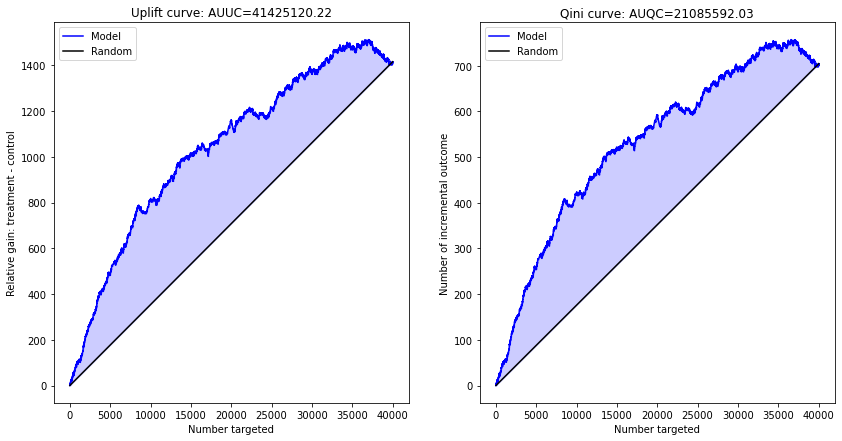

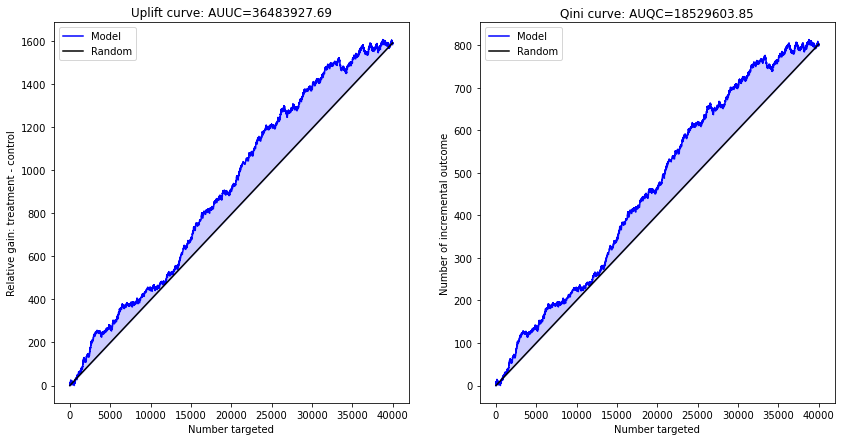

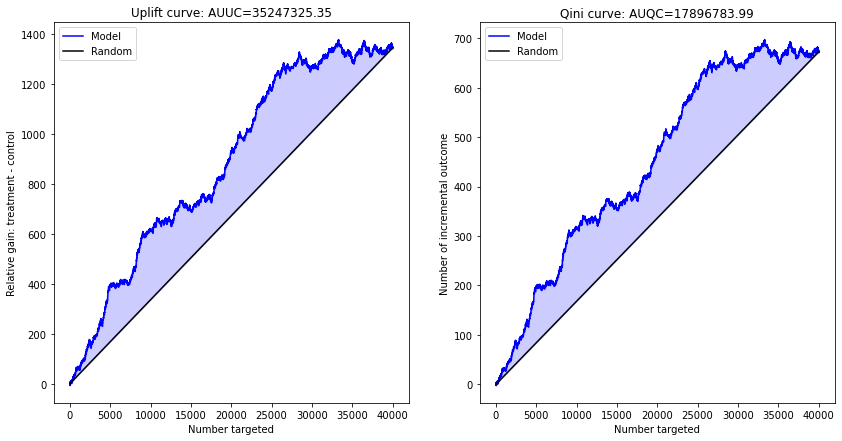

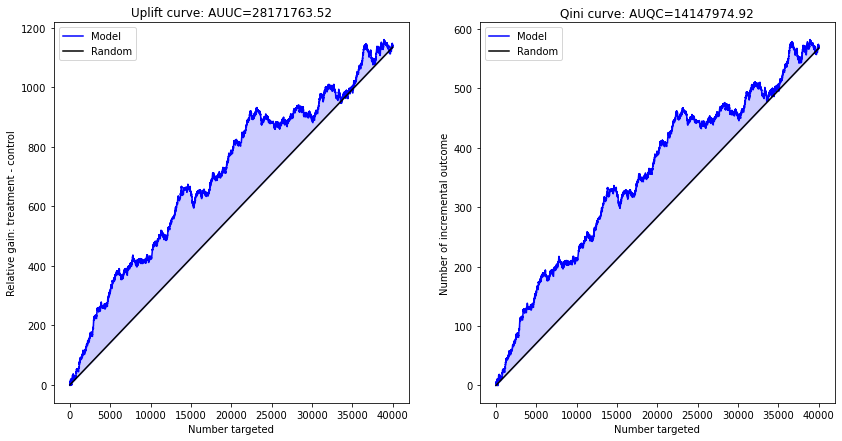

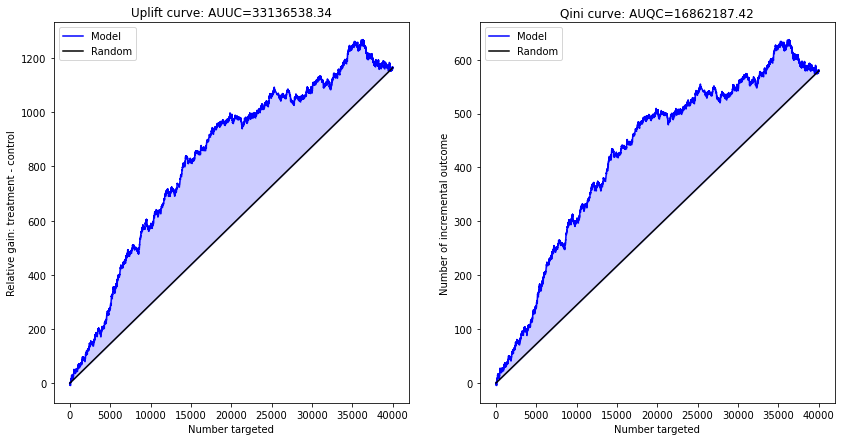

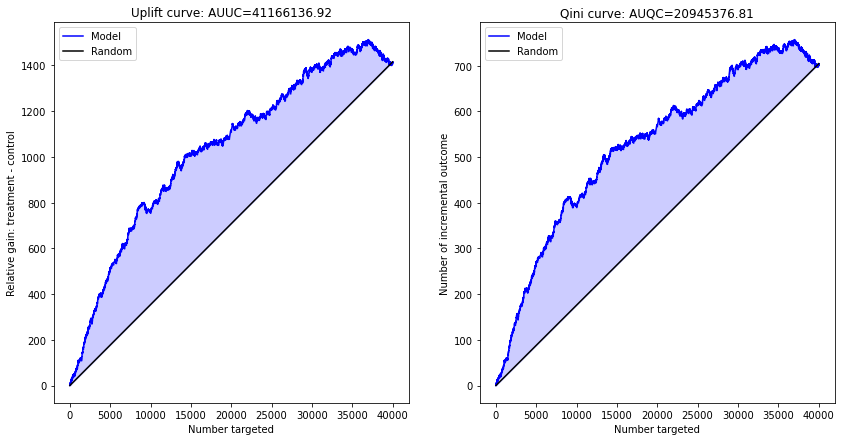

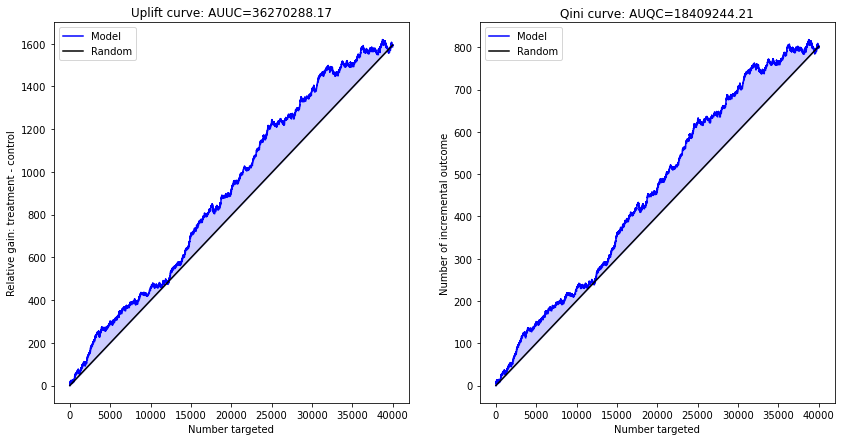

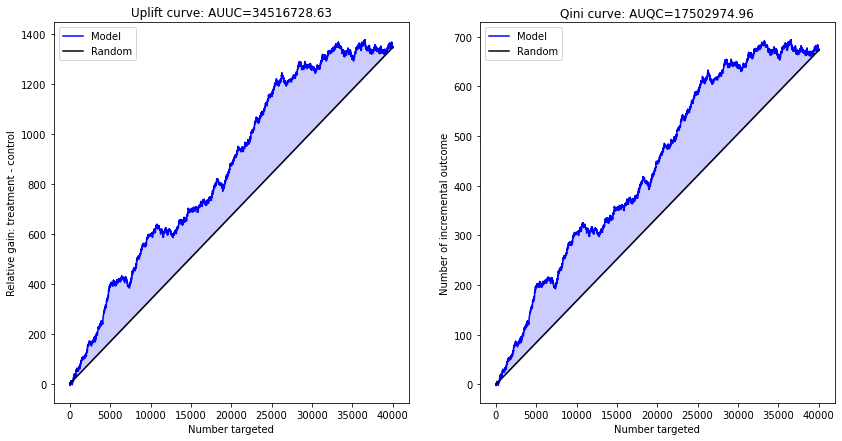

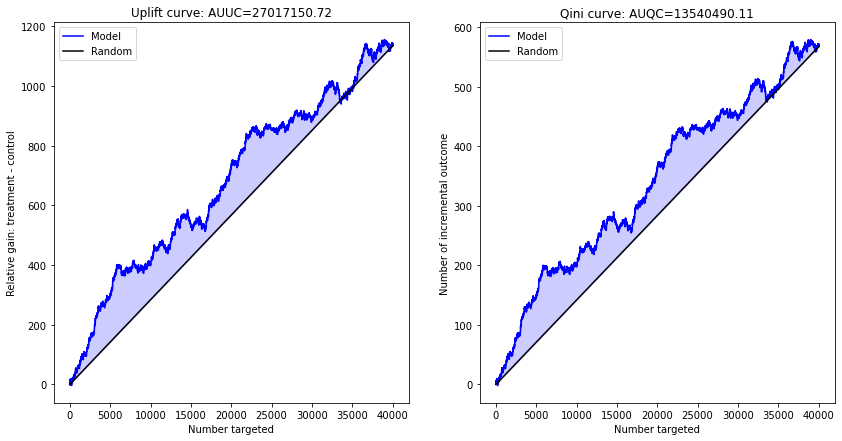

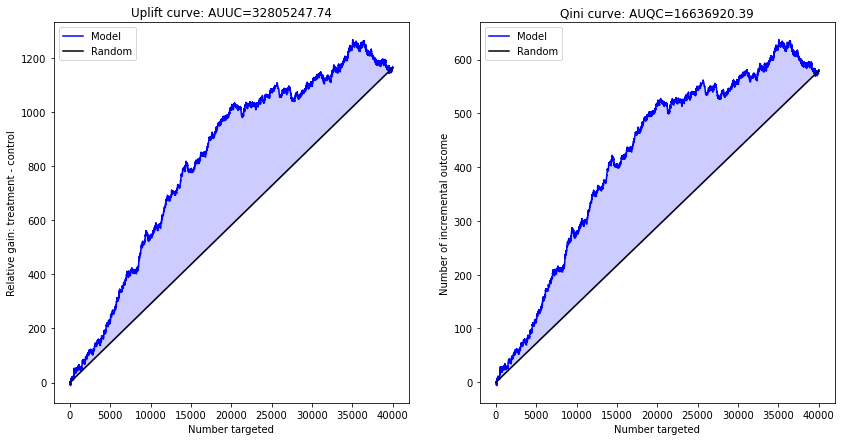

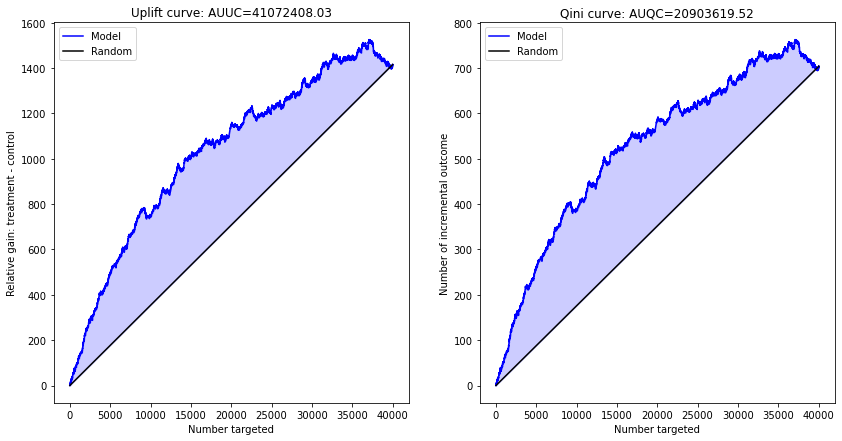

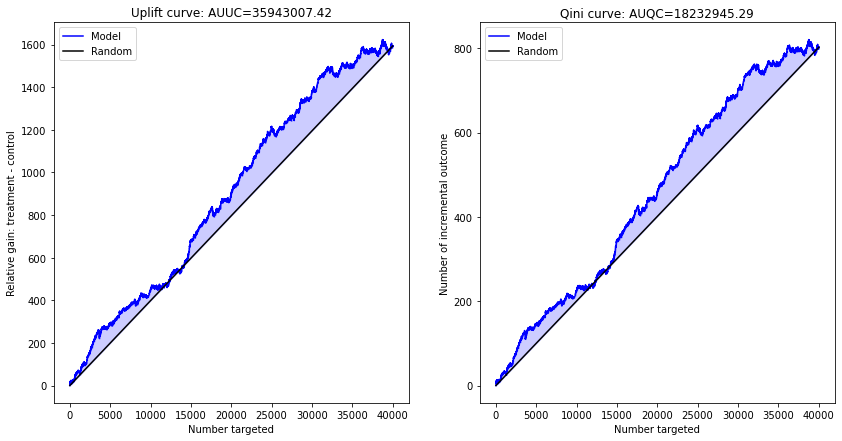

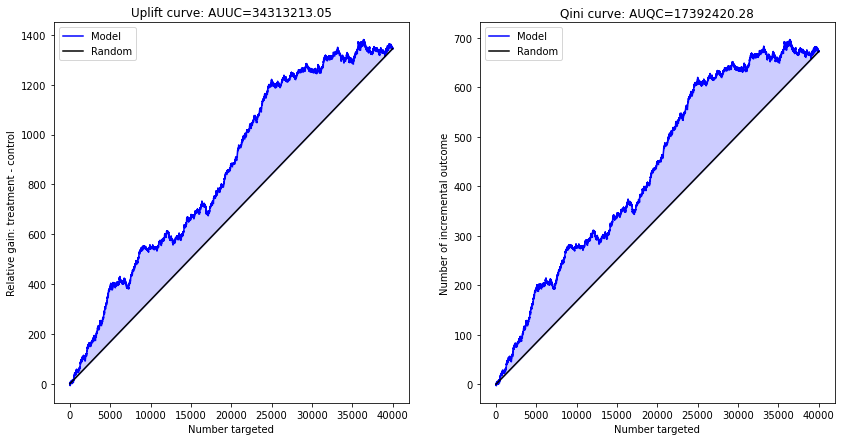

In [5]:
from uplift.metrics import uplift_at_k
from uplift.vizualization import plot_uplift_preds, plot_uplift_qini_curves

n_trees = [1] + list(range(10, 70, 5))

indices_all_folds = np.array_split(indices_train, num_folds)
xgb_score_uplift_30 = []
for n_tree in n_trees:
    val_score = []
    for i in range(num_folds):
        
        
        x_val = X_train.loc[indices_all_folds[i]].values
        y_val = df_train.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_train.loc[indices_all_folds[i]].values
    
    
        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(train_count)
    
        x_train = X_train.loc[united].values
        y_train = df_train.loc[united,'target'].values
        treatment_train = treat_train.loc[united].values
        
        estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, 
                                      n_estimators=n_tree, min_child_weight=3)
        sm = SoloModel(estimator)
       
        sm = sm.fit(x_train, y_train, treatment_train)
        uplift_sm = sm.predict(x_val)
        
        plot_uplift_qini_curves(y_true=y_val, uplift=uplift_sm, treatment=treatment_val)
        
        val_score.append(uplift_at_k(y_true=y_val, uplift=uplift_sm, 
                                     treatment=treatment_val, strategy= "by_group", k=0.3))
        
    xgb_score_uplift_30.append(val_score)

In [7]:
xgb_score_uplift_30 = np.matrix(xgb_score_uplift_30)
print(xgb_score_uplift_30)

[[0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.0301398  0.03206246 0.04982303 0.03684721 0.04146303]
 [0.03013536 0.04178918 0.05292617 0.0431222  0.05544204]
 [0.04044031 0.04172658 0.06027093 0.04507492 0.04928073]
 [0.05408716 0.04660141 0.0732029  0.04253132 0.06975344]
 [0.05758913 0.05456817 0.07250256 0.04201835 0.06975433]
 [0.0502719  0.04958321 0.07348109 0.0447109  0.0601026 ]
 [0.04161423 0.04928267 0.07297317 0.04045798 0.05728029]
 [0.03778786 0.05430696 0.07145471 0.0487273  0.05544893]
 [0.03862161 0.05632322 0.07530618 0.04361628 0.05029145]
 [0.04128451 0.05901595 0.07329224 0.04213167 0.05695057]
 [0.0407847  0.05853646 0.07163824 0.03961877 0.05178954]
 [0.03745414 0.05432006 0.07114631 0.03846041 0.04929073]]


In [155]:
from lightgbm import LGBMClassifier
n_trees = [1] + list(range(10, 70, 5))

indices_all_folds = np.array_split(indices_train, num_folds)
lgbm_score_uplift_30 = []
for n_tree in n_trees:
    val_score = []
    for i in range(num_folds):
        
        
        x_val = X_train.loc[indices_all_folds[i]].values
        y_val = df_train.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_train.loc[indices_all_folds[i]].values
    
    
        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(train_count)
        
        x_train = X_train.loc[united].values
        y_train = df_train.loc[united,'target'].values
        treatment_train = treat_train.loc[united].values
        
        estimator = LGBMClassifier(
        n_estimators = n_tree,
        num_leaves = 33,
        boosting_type='gbdt',
        max_depth=5,
        learning_rate=0.1
    )
        sm = SoloModel(estimator)
        
        sm = sm.fit(x_train, y_train, treatment_train)
        uplift_sm = sm.predict(x_val)
    
        val_score.append(uplift_at_k(y_true=y_val, uplift=uplift_sm, 
                                     treatment=treatment_val, strategy= "by_group", k=0.3))
        
    lgbm_score_uplift_30.append(val_score)

In [73]:
lgbm_score_uplift_30 = np.matrix(lgbm_score_uplift_30)
print(lgbm_score_uplift_30)

[[0.02868059 0.03069513 0.03256329 0.03621856 0.0436661 ]
 [0.0271463  0.04807954 0.04932043 0.02785931 0.0243131 ]
 [0.03379497 0.03968901 0.05422022 0.04142726 0.05711221]
 [0.03661839 0.04936658 0.05173034 0.0370256  0.05078148]
 [0.04893857 0.05771089 0.05575822 0.04201363 0.06244377]
 [0.04061462 0.06124755 0.06581726 0.04463772 0.05844043]
 [0.03911653 0.06308651 0.06698821 0.03758343 0.05495201]
 [0.04278526 0.05686367 0.06629676 0.03605397 0.05378276]
 [0.03995428 0.05953182 0.06257373 0.03973468 0.05711265]
 [0.04162178 0.05837915 0.05465528 0.03792619 0.05411871]
 [0.04112309 0.05604596 0.05133485 0.03961169 0.05494912]
 [0.04095656 0.05203636 0.05167347 0.03578675 0.05428434]
 [0.03962389 0.05001518 0.05118864 0.03709879 0.05278426]]


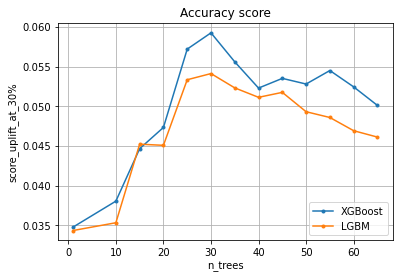

In [74]:
pylab.plot(n_trees, xgb_score_uplift_30.mean(axis = 1), marker='.', label='XGBoost')
pylab.plot(n_trees, lgbm_score_uplift_30.mean(axis = 1), marker='.', label='LGBM')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score_uplift_at_30%')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [79]:
print("Best score lgbm = %f" %(max(lgbm_score_uplift_30.mean(axis=1))))
print("Best score xgboost = %f" %(max(xgb_score_uplift_30.mean(axis=1))))

Best score lgbm = 0.054152
Best score xgboost = 0.059287


## solo, cross val = 5, фиксируем число деревьев, подбираем размер шага (learning rate)

In [80]:
num_folds = 5
val_count = (df_train.shape[0]) // num_folds #volume of validation set
train_count = (df_train.shape[0]) - val_count
print(val_count)
print(train_count)
print(df_train.shape[0])

40007
160028
200035


In [89]:
n_lrates = [0.0001, 0.001, 0.01, 0.1]

indices_all_folds = np.array_split(indices_train, num_folds)
xgb_score_uplift_30_2 = []
for lrate in n_lrates:
    val_score = []
    for i in range(num_folds):
        
        
        x_val = X_train.loc[indices_all_folds[i]].values
        y_val = df_train.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_train.loc[indices_all_folds[i]].values
    
    
        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(train_count)
    
        x_train = X_train.loc[united].values
        y_train = df_train.loc[united,'target'].values
        treatment_train = treat_train.loc[united].values
        
        estimator = xgb.XGBClassifier(learning_rate=lrate, max_depth=5, 
                                      n_estimators=40, min_child_weight=3)
        sm = SoloModel(estimator)
       
        sm = sm.fit(x_train, y_train, treatment_train)
        uplift_sm = sm.predict(x_val)
    
        val_score.append(uplift_at_k(y_true=y_val, uplift=uplift_sm, 
                                     treatment=treatment_val, strategy= "by_group", k=0.3))
        
    xgb_score_uplift_30_2.append(val_score)

In [91]:
xgb_score_uplift_30_2 = np.matrix(xgb_score_uplift_30_2)
print(xgb_score_uplift_30_2)

[[0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.02901676 0.03052601 0.03239398 0.03588524 0.04299999]
 [0.0320127  0.02784967 0.03224422 0.03486166 0.04365766]
 [0.04161423 0.04928267 0.07297317 0.04045798 0.05728029]]


In [92]:
n_lrates = [0.0001, 0.001, 0.01, 0.1]

indices_all_folds = np.array_split(indices_train, num_folds)
lgbm_score_uplift_30_2 = []
for lrate in n_lrates:
    val_score = []
    for i in range(num_folds):
        
        
        x_val = X_train.loc[indices_all_folds[i]].values
        y_val = df_train.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_train.loc[indices_all_folds[i]].values
    
    
        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(train_count)
    
        x_train = X_train.loc[united].values
        y_train = df_train.loc[united,'target'].values
        treatment_train = treat_train.loc[united].values
        
        estimator = LGBMClassifier(
        n_estimators = 40,
        num_leaves = 33,
        boosting_type='gbdt',
        max_depth=5,
        learning_rate=lrate
    )
        sm = SoloModel(estimator)
       
        sm = sm.fit(x_train, y_train, treatment_train)
        uplift_sm = sm.predict(x_val)
    
        val_score.append(uplift_at_k(y_true=y_val, uplift=uplift_sm, 
                                     treatment=treatment_val, strategy= "by_group", k=0.3))
        
    lgbm_score_uplift_30_2.append(val_score)

In [93]:
lgbm_score_uplift_30_2 = np.matrix(lgbm_score_uplift_30_2)
print(lgbm_score_uplift_30_2)

[[0.02868059 0.03069513 0.03256329 0.03621856 0.0436661 ]
 [0.02901676 0.03069513 0.03256329 0.03621856 0.0436661 ]
 [0.03467493 0.03102516 0.03290902 0.03904353 0.04432422]
 [0.04278526 0.05686367 0.06629676 0.03605397 0.05378276]]


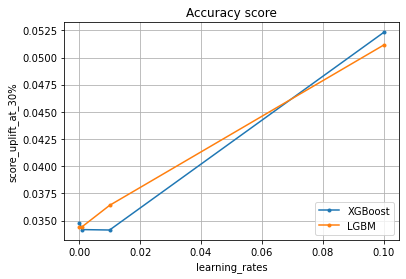

In [94]:
pylab.plot(n_lrates, xgb_score_uplift_30_2.mean(axis = 1), marker='.', label='XGBoost')
pylab.plot(n_lrates, lgbm_score_uplift_30_2.mean(axis = 1), marker='.', label='LGBM')
pylab.grid(True)
pylab.xlabel('learning_rates')
pylab.ylabel('score_uplift_at_30%')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [95]:
print("Best score lgbm = %f" %(max(lgbm_score_uplift_30_2.mean(axis=1))))
print("Best score xgboost = %f" %(max(xgb_score_uplift_30_2.mean(axis=1))))

Best score lgbm = 0.051156
Best score xgboost = 0.052322


## using grid search

In [99]:
from pprint import pprint
from sklearn.model_selection import ParameterGrid

n_estimators = [1] + list(range(10, 70, 5))
learning_rate = [0.0001, 0.001, 0.01, 0.1]

param_grid = {
              'n_estimators': n_estimators,
               'learning_rate': learning_rate}


grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)


In [100]:
indices_all_folds = np.array_split(indices_train, num_folds)
xgb_score_uplift_30_all = []

for params in grid_list:
    val_score = []
    for i in range(num_folds):
        
        
        x_val = X_train.loc[indices_all_folds[i]].values
        y_val = df_train.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_train.loc[indices_all_folds[i]].values
    
    
        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(train_count)
    
        x_train = X_train.loc[united].values
        y_train = df_train.loc[united,'target'].values
        treatment_train = treat_train.loc[united].values
        
        estimator = xgb.XGBClassifier(learning_rate=params["learning_rate"], max_depth=5, 
                                      n_estimators=params["n_estimators"], min_child_weight=3)
        sm = SoloModel(estimator)
       
        sm = sm.fit(x_train, y_train, treatment_train)
        uplift_sm = sm.predict(x_val)
    
        val_score.append(uplift_at_k(y_true=y_val, uplift=uplift_sm, 
                                     treatment=treatment_val, strategy= "by_group", k=0.3))
        
    xgb_score_uplift_30_all.append(val_score)

In [101]:
xgb_score_uplift_30_all = np.matrix(xgb_score_uplift_30_all)
print(xgb_score_uplift_30_all)

[[0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.0436661 ]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.04299999]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.04299999]
 [0.03101109 0.03052601 0.03256329 0.03621856 0.04299999]
 [0.02901653 0

In [119]:
print(len(grid_list))
arr = [i for i in range (0,52)]
print(arr)


52
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
[{'learning_rate': 0.1, 'n_estimators': 1}, {'learning_rate': 0.1, 'n_estimators': 10}, {'learning_rate': 0.1, 'n_estimators': 15}, {'learning_rate': 0.1, 'n_estimators': 20}, {'learning_rate': 0.1, 'n_estimators': 25}, {'learning_rate': 0.1, 'n_estimators': 30}, {'learning_rate': 0.1, 'n_estimators': 35}, {'learning_rate': 0.1, 'n_estimators': 40}, {'learning_rate': 0.1, 'n_estimators': 45}, {'learning_rate': 0.1, 'n_estimators': 50}, {'learning_rate': 0.1, 'n_estimators': 55}, {'learning_rate': 0.1, 'n_estimators': 60}, {'learning_rate': 0.1, 'n_estimators': 65}]


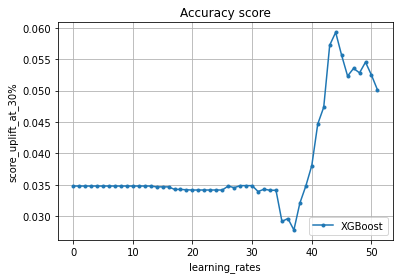

In [116]:
pylab.plot(arr, xgb_score_uplift_30_all.mean(axis = 1), marker='.', label='XGBoost')

pylab.grid(True)
pylab.xlabel('learning_rates')
pylab.ylabel('score_uplift_at_30%')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [112]:
print("Best score xgboost = %f" %(max(xgb_score_uplift_30_all.mean(axis=1))))

Best score xgboost = 0.059287


In [120]:
print(df_test)

Empty DataFrame
Columns: []
Index: [000048b7a6, 000073194a, 00007c7133, 00007f9014, 0000a90cf7, 0000b59cec, 0000bb4e4e, 0000bcec9c, 0000eecb82, 0000f0ecdb, 0003363542, 00034f1549, 00037a9650, 0003b55871, 00049b7bae, 0004b68a3a, 0004ce2e52, 0004d028a5, 00051d6b59, 00055427d8, 0005ce475d, 0005d47bbf, 000687035e, 0006c801df, 0006f7f5cf, 0007379fdc, 00075162b6, 00077c053e, 0007c203da, 0008017403, 00087f07ea, 0008a9cf61, 0008eceb3c, 00091e04ca, 000926cf86, 0009545f90, 0009d3f2f6, 0009faeb8a, 000a240963, 000a3e3c00, 000aaffaed, 000ad99332, 000aef1e0b, 000af410d8, 000b397480, 000b585ab3, 000ba237bf, 000bcb2fe5, 000c05054d, 000c2677f6, 000c4ff46f, 000c56cea0, 000c6e91c8, 000c9409e1, 000c94c607, 000d007ae1, 000d4661c7, 000d743b7a, 000ee3b330, 000ee5104e, 000f064b75, 000f21f19a, 000f62d628, 000f8ae5d6, 000fbdbf4b, 00100bc1b2, 00105a51be, 00108635ca, 0010a047fb, 0011530aaa, 00115952a0, 001164992a, 00121553fa, 00129d119c, 0012b6cac6, 00132e311c, 001364541a, 00139c3ad9, 0014722cf2, 0014d2fb96, 0015

In [162]:
x_train = X_train.values
y_train = df_train['target'].values
treatment_train = treat_train.values


estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, 
                                      n_estimators=30, min_child_weight=3)
sm = SoloModel(estimator)
sm = sm.fit(x_train, y_train, treatment_train)
uplift_sm = sm.predict(x_train)

score = uplift_at_k(y_true=y_train, uplift=uplift_sm, 
                                     treatment=treatment_train, strategy= "by_group", k=0.3)
print(score)

0.06848473461572202
